In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import os


import matplotlib.gridspec as gridspec

In [2]:
def journal():
    '''
    Appears nearly square. I like this best.
    'figure.figsize': [3.1, 2.6]
    
    Use: plt.tight_layout(pad=0.1, w_pad=0.0, h_pad=0.0)
    plt.xlabel('$E_{iso}$ $(erg)$',labelpad=-1)  
    plt.ylabel('$E^*_{pk}$ $(keV)$',labelpad=-2)
    
    '''
    params = {'backend': 'pdf',
              'axes.labelsize':  10,
              'font.size':       10,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'text.usetex':     True,
              'figure.figsize': [4,3], #[4,3], #[3.1, 2.6], # [7,6]
              'font.family': 'serif',}
    plt.rcParams.update(params)
    
    

In [3]:
journal()

# Functions

In [4]:
sum_of_squares    = lambda values: sum( [i**2 for i in values] )
root_mean_square  = lambda values: np.sqrt( sum_of_squares(values) / len(values) )

In [5]:
def fix_dataframe(df):
    '''
    Dataframes contain unlogged values and unlogged margins of errors on 
    Eiso, Epeak, and EpeakRest
    We must log all of the values and their errors, however, we must 
    find the upper and lower confidence intervals first and log those. 
    We can not simply take np.log of a margin of error. 
    '''
    dfc = df.copy()
    # LOG10 THE EISO, EPEAK, AND NORM PARAMS
    for param in ['eiso','norm','epeak','epeakRest']:
        
        value     = df[param]  # value must be unlogged
        errL      = eval('df.%s_err_low'%param) # leave unlogged
        errU      = eval('df.%s_err_up'%param) # leave unlogged
        # UNLOGGED CONFIDENCE INTERVALS, LOWER AND UPPER.
        CI_L = value - errL
        CI_U = value + errU

        # COMPUTE LOGGED MARGIN OF ERRORS - moe stands for margin of error
        # LOGGED VALUE - LOGGED CI
        moeL = np.log10( value ) - np.log10( CI_L )
        moeU = np.log10( CI_U ) - np.log10( value )
        
        dfc[param] = np.log10( df[param] ) 
        dfc['%s_err_low'%param]  = moeL
        dfc['%s_err_up'%param]   = moeU
    return dfc


# BAND FUNCTION

# xLab        = '10keV-10MeV'
# yLab        = '10keV-10GeV'

/Users/KimiZ/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/KimiZ/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/eiso_10keV_10MeV_10keV_10GeV_BAND35.pdf


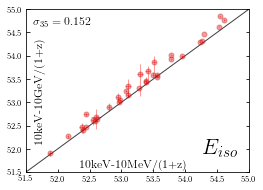

In [15]:
df1    = pd.read_csv('/Users/KimiZ/GRBs2/Sample/Band_13_GBM+LAT__22_GBMconstrained.txt', sep='\t', header=0)
df1['Eiso2']

df1['Eiso2'][df1['trigger'] == 'bn111228657'] = 2.536767E52 # up to 7.1 GeV
df1['Eiso2'][df1['trigger'] == 'bn130925173'] = 2.938458E52 # up to 9.5 GeV

df2 = df1.copy()

df2['eiso'] = df1['Eiso2']
df2['eiso_err_low'] = df1['Eiso2_err']
df2['eiso_err_up'] = df1['Eiso2_err']

# LOG THE APPROPRIATE PARAMETERS IN EACH DATAFRAME.    
df1 = fix_dataframe(df1)
df2 = fix_dataframe(df2)


param = 'eiso'

xLab        = '10keV-10MeV'
yLab        = '10keV-10GeV'

plt.clf()


parlab       = r'$E_{iso}$'
axesLims     = [51.5, 55]

sigma_rms = root_mean_square(eval('df1.%s'%param) - eval('df2.%s'%param))

xline = np.linspace(axesLims[0], axesLims[1], 100)
yline = 1*xline+0
plt.plot(xline, yline, color='black', ls='-', lw=1, alpha=0.75)

plt.errorbar(x       = eval('df1.%s'%param), 
             y       = eval('df2.%s'%param), 
             xerr    = [eval('df1.%s_err_low'%param), eval('df1.%s_err_up'%param)], 
             yerr    = [eval('df2.%s_err_low'%param), eval('df2.%s_err_up'%param)], 
             fmt = 'o', capsize = None, 
             color = 'red', ecolor = 'red', 
             ms=5, mec='brown', elinewidth=1, alpha=0.4)

plt.xlim(axesLims[0], axesLims[1])
plt.ylim(axesLims[0], axesLims[1])

plt.figtext(0.15, 0.8, r'$\sigma_{%i}=%.3f$'%(len(df1), sigma_rms), fontsize=12, color ='black') 

plt.figtext(0.5, 0.15, '%s/(1+z)'%xLab, fontsize=12,
            horizontalalignment='center',)
plt.figtext(0.15, 0.5, '%s/(1+z)'%yLab, fontsize=12, 
            verticalalignment='center', rotation=90)

plt.figtext(0.8, 0.2, '%s'%parlab, 
            horizontalalignment='center', fontsize=22)
#plt.show()

filename = '/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/%s_%s_%s_BAND%i.pdf'%(param, xLab, yLab, len(df1))
filename = filename.replace(' ', '_')
filename = filename.replace('-', '_')
print(filename)
plt.savefig(filename)
#os.system('open %s'%filename)


# SBPL function

/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/eiso_10keV_10MeV_10keV_10GeV_SBPL32.pdf


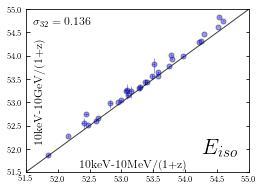

In [16]:

df1    = pd.read_csv('/Users/KimiZ/GRBs2/Sample/SBPL_13_GBM+LAT__19_GBMconstrained.txt', sep='\t', header=0)

df2 = df1.copy()

df2['eiso'] = df1['Eiso2']
df2['eiso_err_low'] = df1['Eiso2_err']
df2['eiso_err_up'] = df1['Eiso2_err']

# LOG THE APPROPRIATE PARAMETERS IN EACH DATAFRAME.    
df1 = fix_dataframe(df1)
df2 = fix_dataframe(df2)


param = 'eiso'

xLab        = '10keV-10MeV'
yLab        = '10keV-10GeV'

plt.clf()


parlab       = r'$E_{iso}$'
axesLims     = [51.5, 55]

sigma_rms = root_mean_square(eval('df1.%s'%param) - eval('df2.%s'%param))

xline = np.linspace(axesLims[0], axesLims[1], 100)
yline = 1*xline+0
plt.plot(xline, yline, color='black', ls='-', lw=1, alpha=0.75)

plt.errorbar(x       = eval('df1.%s'%param), 
             y       = eval('df2.%s'%param), 
             xerr    = [eval('df1.%s_err_low'%param), eval('df1.%s_err_up'%param)], 
             yerr    = [eval('df2.%s_err_low'%param), eval('df2.%s_err_up'%param)], 
             fmt = 'o', capsize = None, 
             color = 'blue', ecolor = 'blue', 
             ms=5, mec='black', elinewidth=1, alpha=0.4)

plt.xlim(axesLims[0], axesLims[1])
plt.ylim(axesLims[0], axesLims[1])

plt.figtext(0.15, 0.8, r'$\sigma_{%i}=%.3f$'%(len(df1), sigma_rms), fontsize=12, color ='black') 

plt.figtext(0.5, 0.15, '%s/(1+z)'%xLab, fontsize=12,
            horizontalalignment='center',)
plt.figtext(0.15, 0.5, '%s/(1+z)'%yLab, fontsize=12, 
            verticalalignment='center', rotation=90)

plt.figtext(0.8, 0.2, '%s'%parlab, 
            horizontalalignment='center', fontsize=22)
#plt.show()

filename = '/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/%s_%s_%s_SBPL%i.pdf'%(param, xLab, yLab, len(df1))
filename = filename.replace(' ', '_')
filename = filename.replace('-', '_')
print(filename)
plt.savefig(filename)
#os.system('open %s'%filename)


#  xLab        = '10keV-10MeV'
#  yLab        = '1keV-10MeV'

/Users/KimiZ/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/KimiZ/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/eiso_10keV_10MeV_1keV_10MeV_BAND35.pdf


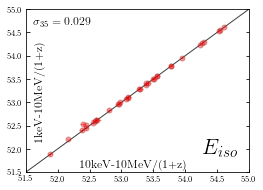

In [17]:
df1    = pd.read_csv('/Users/KimiZ/GRBs2/Sample/Band_13_GBM+LAT__22_GBMconstrained.txt', sep='\t', header=0)
df1['Eiso2']
#df1     = data[data.LATburst == 'Y'] # GBM+LAT

df1['Eiso2'][df1['trigger'] == 'bn111228657'] = 2.536767E52 # up to 7.1 GeV
df1['Eiso2'][df1['trigger'] == 'bn130925173'] = 2.938458E52 # up to 9.5 GeV

df2 = df1.copy()

df2['eiso']            = df1['Eiso3']
df2['eiso_err_low']    = df1['Eiso3_err']
df2['eiso_err_up']     = df1['Eiso3_err']

# LOG THE APPROPRIATE PARAMETERS IN EACH DATAFRAME.    
df1 = fix_dataframe(df1)
df2 = fix_dataframe(df2)


param = 'eiso'

xLab        = '10keV-10MeV'
yLab        = '1keV-10MeV'

plt.clf()


parlab       = r'$E_{iso}$'
axesLims     = [51.5, 55]

sigma_rms = root_mean_square(eval('df1.%s'%param) - eval('df2.%s'%param))

xline = np.linspace(axesLims[0], axesLims[1], 100)
yline = 1*xline+0
plt.plot(xline, yline, color='black', ls='-', lw=1, alpha=0.75)

plt.errorbar(x       = eval('df1.%s'%param), 
             y       = eval('df2.%s'%param), 
             xerr    = [eval('df1.%s_err_low'%param), eval('df1.%s_err_up'%param)], 
             yerr    = [eval('df2.%s_err_low'%param), eval('df2.%s_err_up'%param)], 
             fmt = 'o', capsize = None, 
             color = 'red', ecolor = 'red', 
             ms=5, mec='brown', elinewidth=1, alpha=0.4)

plt.xlim(axesLims[0], axesLims[1])
plt.ylim(axesLims[0], axesLims[1])

plt.figtext(0.15, 0.8, r'$\sigma_{%i}=%.3f$'%(len(df1), sigma_rms), fontsize=12, color ='black') 

plt.figtext(0.5, 0.15, '%s/(1+z)'%xLab, fontsize=12,
            horizontalalignment='center',)
plt.figtext(0.15, 0.5, '%s/(1+z)'%yLab, fontsize=12, 
            verticalalignment='center', rotation=90)

plt.figtext(0.8, 0.2, '%s'%parlab, 
            horizontalalignment='center', fontsize=22)
#plt.show()

filename = '/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/%s_%s_%s_BAND%i.pdf'%(param, xLab, yLab, len(df1))
filename = filename.replace(' ', '_')
filename = filename.replace('-', '_')
print(filename)
plt.savefig(filename)
#os.system('open %s'%filename)


# SBPL function

/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/eiso_10keV_10MeV_1keV_10MeV_SBPL32.pdf


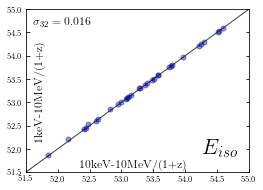

In [18]:
df1    = pd.read_csv('/Users/KimiZ/GRBs2/Sample/SBPL_13_GBM+LAT__19_GBMconstrained.txt', sep='\t', header=0)

df2 = df1.copy()

df2['eiso']            = df1['Eiso3']
df2['eiso_err_low']    = df1['Eiso3_err']
df2['eiso_err_up']     = df1['Eiso3_err']

# LOG THE APPROPRIATE PARAMETERS IN EACH DATAFRAME.    
df1 = fix_dataframe(df1)
df2 = fix_dataframe(df2)


param = 'eiso'

xLab        = '10keV-10MeV'
yLab        = '1keV-10MeV'

plt.clf()


parlab       = r'$E_{iso}$'
axesLims     = [51.5, 55]

sigma_rms = root_mean_square(eval('df1.%s'%param) - eval('df2.%s'%param))

xline = np.linspace(axesLims[0], axesLims[1], 100)
yline = 1*xline+0
plt.plot(xline, yline, color='black', ls='-', lw=1, alpha=0.75)

plt.errorbar(x       = eval('df1.%s'%param), 
             y       = eval('df2.%s'%param), 
             xerr    = [eval('df1.%s_err_low'%param), eval('df1.%s_err_up'%param)], 
             yerr    = [eval('df2.%s_err_low'%param), eval('df2.%s_err_up'%param)], 
             fmt = 'o', capsize = None, 
             color = 'blue', ecolor = 'blue', 
             ms=5, mec='black', elinewidth=1, alpha=0.4)

plt.xlim(axesLims[0], axesLims[1])
plt.ylim(axesLims[0], axesLims[1])

plt.figtext(0.15, 0.8, r'$\sigma_{%i}=%.3f$'%(len(df1), sigma_rms), fontsize=12, color ='black') 

plt.figtext(0.5, 0.15, '%s/(1+z)'%xLab, fontsize=12,
            horizontalalignment='center',)
plt.figtext(0.15, 0.5, '%s/(1+z)'%yLab, fontsize=12, 
            verticalalignment='center', rotation=90)

plt.figtext(0.8, 0.2, '%s'%parlab, 
            horizontalalignment='center', fontsize=22)
#plt.show()

filename = '/Users/KimiZ/GRBs2/python_modeling/EisoComparisonPlots/%s_%s_%s_SBPL%i.pdf'%(param, xLab, yLab, len(df1))
filename = filename.replace(' ', '_')
filename = filename.replace('-', '_')
print(filename)
plt.savefig(filename)
#os.system('open %s'%filename)
